# Iteration 4:  Marine Life Distribution

Author: Chinchien Lin
UPI: clin864
Email: clin864@aucklanduni.ac.nz
Student ID: 938149604
GitHub: https://github.com/LIN810116/INFOSYS-722---Iteration-4

### Import

In [1]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
import pandas
from pyspark.sql.functions import lit
from pyspark.sql.functions import abs
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import regexp_replace

#Import dataset
    #inferSchema: for CSV
df = spark.read.csv('marineLife(I4).csv',header=True,inferSchema=True)

# Data understanding

In [2]:
print("Number of Row:", df.count())
df.show()

Number of Row: 5634
+----------+-----------+-----------------+---------------+-----------------+-------------+--------------------+---------+---------+
| SpeciesID|      Class|            Order|         Family|            Genus|      Species|    Scientific names|WMostLong|EMostLong|
+----------+-----------+-----------------+---------------+-----------------+-------------+--------------------+---------+---------+
| Fis-29581|Actinopteri|      Perciformes|   Acanthuridae|       Acanthurus|    monroviae|Acanthurus monroviae|       NA|       NA|
| Fis-26602|Actinopteri|Pleuronectiformes|      Achiridae|        Trinectes|  paulistanus|Trinectes paulist...|      -55|      -30|
| Fis-27804|Actinopteri|Pleuronectiformes|      Achiridae|          Achirus|   mazatlanus|  Achirus mazatlanus|     -120|      -70|
| Fis-28886|Actinopteri|Pleuronectiformes|      Achiridae|        Trinectes|   fimbriatus|Trinectes fimbriatus|       NA|       NA|
| Fis-28885|Actinopteri|Pleuronectiformes|      Achirida

In [3]:
# data structure 
df.printSchema()

root
 |-- SpeciesID: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Order: string (nullable = true)
 |-- Family: string (nullable = true)
 |-- Genus: string (nullable = true)
 |-- Species: string (nullable = true)
 |-- Scientific names: string (nullable = true)
 |-- WMostLong: string (nullable = true)
 |-- EMostLong: string (nullable = true)



In [4]:
# get general statistics 
df.describe().show()

+-------+---------+------------+----------------+------------+-------------+-------+--------------------+-----------------+------------------+
|summary|SpeciesID|       Class|           Order|      Family|        Genus|Species|    Scientific names|        WMostLong|         EMostLong|
+-------+---------+------------+----------------+------------+-------------+-------+--------------------+-----------------+------------------+
|  count|     5631|        5631|            5631|        5631|         5631|   5631|                5631|             5631|              5631|
|   mean|     null|        null|            null|        null|         null|   null|                null|-17.3216218097304|-2.333721291123526|
| stddev|     null|        null|            null|        null|         null|   null|                null| 93.1836869615287|114.34758239286916|
|    min|Fis-10312| Actinopteri|Acipenseriformes|Acanthuridae|    Abalistes|abaster| Abalistes stellaris|               -1|                -1|

In [5]:
# get general statistics of longitude features
df.select('WMostLong', 'EMostLong').describe().show()

+-------+-----------------+------------------+
|summary|        WMostLong|         EMostLong|
+-------+-----------------+------------------+
|  count|             5631|              5631|
|   mean|-17.3216218097304|-2.333721291123526|
| stddev| 93.1836869615287|114.34758239286916|
|    min|               -1|                -1|
|    max|               NA|                NA|
+-------+-----------------+------------------+



In [6]:
# check unique value
print("Number of unique value:")
print("Class:", df.select('Class').distinct().count())
print("Order:", df.select('Order').distinct().count())
print("Order:", df.select('Family').distinct().count())
print("Genus:", df.select('Genus').distinct().count())
print("Species:", df.select('Species').distinct().count())
print("Scientific names:", df.select('Scientific names').distinct().count())

Number of unique value:
Class: 7
Order: 58
Order: 355
Genus: 1812
Species: 3961
Scientific names: 5632


In [7]:
# for example: Class
df.groupBy('Class').count().show()

+--------------+-----+
|         Class|count|
+--------------+-----+
|Elasmobranchii|  472|
|          null|    3|
|   Actinopteri| 5127|
|        Myxini|    7|
|   Holocephali|   18|
|   Coelacanthi|    1|
|  Petromyzonti|    6|
+--------------+-----+



In [8]:
# Check missing value
pd = df.toPandas()
pd.isnull().sum()

SpeciesID           3
Class               3
Order               3
Family              3
Genus               3
Species             3
Scientific names    3
WMostLong           3
EMostLong           3
dtype: int64

In [9]:
# Check "NA"
NA_W = df.filter("WMostLong == 'NA'").count()
NA_E = df.filter("EMostLong == 'NA'").count()
print("Number of NA values in WMostLong: ", NA_W)
print("Number of NA values in EMostLong: ", NA_E)

Number of NA values in WMostLong:  2404
Number of NA values in EMostLong:  2409


In [10]:
# Check "NA": East and Eest
NA_WE = df.filter("WMostLong == 'NA' and EMostLong == 'NA'").count()
print("Number of NA values in WMostLong and EMostLong: ", NA_WE)

Number of NA values in WMostLong and EMostLong:  2402


In [11]:
# Check outliers
outliersW = df.filter("WMostLong > 180 or WMostLong < -180").count()
outliersE = df.filter("EMostLong > 180 or EMostLong < -180").count()
print("Outliers of WMostLong:", outliersW)
print("Outliers of EMostLong:", outliersE)

Outliers of WMostLong: 0
Outliers of EMostLong: 0


# Data Preparation

In [12]:
# select useful parameters
df_pre = df.select('Class', 'Order', 'Family', 'WMostLong', 'EMostLong')
df_pre.show(10)

+-----------+-----------------+------------+---------+---------+
|      Class|            Order|      Family|WMostLong|EMostLong|
+-----------+-----------------+------------+---------+---------+
|Actinopteri|      Perciformes|Acanthuridae|       NA|       NA|
|Actinopteri|Pleuronectiformes|   Achiridae|      -55|      -30|
|Actinopteri|Pleuronectiformes|   Achiridae|     -120|      -70|
|Actinopteri|Pleuronectiformes|   Achiridae|       NA|       NA|
|Actinopteri|Pleuronectiformes|   Achiridae|       NA|       NA|
|Actinopteri|Pleuronectiformes|   Achiridae|       NA|       NA|
|Actinopteri|Pleuronectiformes|   Achiridae|       NA|       NA|
|Actinopteri|Pleuronectiformes|   Achiridae|      -79|      -74|
|Actinopteri|Pleuronectiformes|   Achiridae|      -98|      -73|
|Actinopteri|Pleuronectiformes|   Achiridae|       NA|       NA|
+-----------+-----------------+------------+---------+---------+
only showing top 10 rows



In [13]:
# remove the rows which has nulls in WMostLong and EMostLong
df_pre = df_pre.filter("WMostLong != '' and WMostLong != 'NA' and EMostLong != '' and EMostLong != 'NA'")
#filling missing values
df_pre = df_pre.na.fill('Unknown', subset=['Class', 'Order', 'Family'])

print("Number of Row:", df_pre.count())
# Check missing value
pd_pre = df_pre.toPandas()
print("Check null values:")
display(pd_pre.isnull().sum())

Number of Row: 3220
Check null values:


Class        0
Order        0
Family       0
WMostLong    0
EMostLong    0
dtype: int64

In [14]:
#filling missing values
df_pre = df_pre.na.fill('Unknown', subset=['Class', 'Order', 'Family'])
# Check missing value
pd_pre = df_pre.toPandas()
pd_pre.isnull().sum()

Class        0
Order        0
Family       0
WMostLong    0
EMostLong    0
dtype: int64

In [15]:
# remove outliers
df_pre = df_pre.filter("WMostLong < 180 and WMostLong > -180")
df_pre = df_pre.filter("EMostLong < 180 and EMostLong > -180")

### Create new columns

In [16]:
# converting the data type for EMostLong and WMostLong
df_pre = df_pre.withColumn("EMostLong", df_pre.EMostLong.cast(DoubleType()))
df_pre = df_pre.withColumn("WMostLong", df_pre.WMostLong.cast(DoubleType()))
# Create new columns
# Coverage
df_pre = df_pre.withColumn("Coverage", abs(df_pre.EMostLong - df_pre.WMostLong))
# Level
df_pre = df_pre.withColumn("Level", lit(df_pre.Coverage / 30))
df_pre = df_pre.withColumn("Level", df_pre.Level.cast(IntegerType()))
#isWide
df_pre = df_pre.withColumn("isWide", lit(df_pre.Coverage / 180))
df_pre = df_pre.withColumn("isWide", df_pre.isWide.cast(IntegerType()))

print("Number of Row:", df_pre.count())
df_pre.show()

Number of Row: 3021
+-----------+-----------------+-------------+---------+---------+--------+-----+------+
|      Class|            Order|       Family|WMostLong|EMostLong|Coverage|Level|isWide|
+-----------+-----------------+-------------+---------+---------+--------+-----+------+
|Actinopteri|Pleuronectiformes|    Achiridae|    -55.0|    -30.0|    25.0|    0|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|   -120.0|    -70.0|    50.0|    1|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|    -79.0|    -74.0|     5.0|    0|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|    -98.0|    -73.0|    25.0|    0|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|   -102.0|    -33.0|    69.0|    2|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    -97.0|    132.0|   229.0|    7|     1|
|Actinopteri| Acipenseriformes|Acipenseridae|   -163.0|   -107.0|    56.0|    1|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    -82.0|    -65.0|    17.0|    0|     0|
|Actinopteri

In [17]:
df_pre.printSchema()

root
 |-- Class: string (nullable = false)
 |-- Order: string (nullable = false)
 |-- Family: string (nullable = false)
 |-- WMostLong: double (nullable = true)
 |-- EMostLong: double (nullable = true)
 |-- Coverage: double (nullable = true)
 |-- Level: integer (nullable = true)
 |-- isWide: integer (nullable = true)



# Data transformation

In [18]:
df_pre = df_pre.select('Class', 'Order', 'Family', 'Level', 'isWide')
df_pre.show()

+-----------+-----------------+-------------+-----+------+
|      Class|            Order|       Family|Level|isWide|
+-----------+-----------------+-------------+-----+------+
|Actinopteri|Pleuronectiformes|    Achiridae|    0|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|    1|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|    0|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|    0|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    2|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    7|     1|
|Actinopteri| Acipenseriformes|Acipenseridae|    1|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    0|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    1|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    0|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    2|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    1|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    0|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|    1|     

In [19]:
df_pre.describe().show()
df_pre.groupBy('isWide').count().show()

+-------+------------+----------------+------------+------------------+-------------------+
|summary|       Class|           Order|      Family|             Level|             isWide|
+-------+------------+----------------+------------+------------------+-------------------+
|  count|        3021|            3021|        3021|              3021|               3021|
|   mean|        null|            null|        null| 2.562727573651109|0.16120489904005297|
| stddev|        null|            null|        null|2.6081484085060116|0.36778071414614144|
|    min| Actinopteri|Acipenseriformes|Acanthuridae|                 0|                  0|
|    max|Petromyzonti|       Zeiformes|   Zoarcidae|                11|                  1|
+-------+------------+----------------+------------+------------------+-------------------+

+------+-----+
|isWide|count|
+------+-----+
|     1|  487|
|     0| 2534|
+------+-----+



### Subset 1: Level

In [20]:
df_Level = df_pre.select('Class', 'Order', 'Family', 'Level')
df_Level.show(10)

+-----------+-----------------+-------------+-----+
|      Class|            Order|       Family|Level|
+-----------+-----------------+-------------+-----+
|Actinopteri|Pleuronectiformes|    Achiridae|    0|
|Actinopteri|Pleuronectiformes|    Achiridae|    1|
|Actinopteri|Pleuronectiformes|    Achiridae|    0|
|Actinopteri|Pleuronectiformes|    Achiridae|    0|
|Actinopteri| Acipenseriformes|Acipenseridae|    2|
|Actinopteri| Acipenseriformes|Acipenseridae|    7|
|Actinopteri| Acipenseriformes|Acipenseridae|    1|
|Actinopteri| Acipenseriformes|Acipenseridae|    0|
|Actinopteri| Acipenseriformes|Acipenseridae|    1|
|Actinopteri| Acipenseriformes|Acipenseridae|    0|
+-----------+-----------------+-------------+-----+
only showing top 10 rows



### Subset 2: isWide

In [21]:
df_isWide = df_pre.select('Class', 'Order', 'Family', 'isWide')
df_isWide.show(10)

+-----------+-----------------+-------------+------+
|      Class|            Order|       Family|isWide|
+-----------+-----------------+-------------+------+
|Actinopteri|Pleuronectiformes|    Achiridae|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|     0|
|Actinopteri|Pleuronectiformes|    Achiridae|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|     1|
|Actinopteri| Acipenseriformes|Acipenseridae|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|     0|
|Actinopteri| Acipenseriformes|Acipenseridae|     0|
+-----------+-----------------+-------------+------+
only showing top 10 rows



### Test design

In [22]:
trainData_Level,testData_Level = df_Level.randomSplit([0.7,0.3])
trainData_isWide,testData_isWide = df_isWide.randomSplit([0.7,0.3])

In [23]:
# check out the count.
trainData_Level.describe().show()
testData_Level.describe().show()

+-------+------------+----------------+------------+------------------+
|summary|       Class|           Order|      Family|             Level|
+-------+------------+----------------+------------+------------------+
|  count|        2088|            2088|        2088|              2088|
|   mean|        null|            null|        null|2.5613026819923372|
| stddev|        null|            null|        null| 2.597790633355744|
|    min| Actinopteri|Acipenseriformes|Acanthuridae|                 0|
|    max|Petromyzonti|       Zeiformes|   Zoarcidae|                11|
+-------+------------+----------------+------------+------------------+

+-------+------------+----------------+------------+------------------+
|summary|       Class|           Order|      Family|             Level|
+-------+------------+----------------+------------+------------------+
|  count|         933|             933|         933|               933|
|   mean|        null|            null|        null|2.565916398

### Mining

### Multiclass:   Level

In [24]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)
# First create a string indexer which converts every string into a number, such as male = 0 and female = 1.
# A number will be assigned to every category in the column.
Class_indexer = StringIndexer(inputCol='Class',outputCol='ClassIndex')
Order_indexer = StringIndexer(inputCol='Order',outputCol='OrderIndex')
Family_indexer = StringIndexer(inputCol='Family',outputCol='FamilyIndex')

Level_indexer = StringIndexer(inputCol='Level',outputCol='label')

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# Multiple columns are collapsed into one. 
# This makes it easier to process when you have multiple classes.
Class_encoder = OneHotEncoder(inputCol='ClassIndex',outputCol='ClassVec')
Order_encoder = OneHotEncoder(inputCol='OrderIndex',outputCol='OrderVec')
Family_encoder = OneHotEncoder(inputCol='FamilyIndex',outputCol='FamilyVec')

# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['ClassVec','OrderVec','FamilyVec'], outputCol="features")

In [25]:
from pyspark.ml import Pipeline
# Then go through our steps. It's essentially sequential to the above.
pipeline_Level = Pipeline(stages=[Class_indexer, Order_indexer, Family_indexer, Level_indexer, Class_encoder, Order_encoder, Family_encoder, assembler])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline_Level.fit(df_Level)

# Incorporate results into a new DataFrame.
#pipe_df_Level = pipeline_model.transform(df_Level)
pipe_df = pipeline_model.transform(df_Level)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')

In [26]:
from pyspark.ml import Pipeline
# Then go through our steps. It's essentially sequential to the above.
pipeline_Level = Pipeline(stages=[Class_indexer, Order_indexer, Family_indexer, Level_indexer, Class_encoder, Order_encoder, Family_encoder, assembler])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline_Level.fit(df_Level)

# Incorporate results into a new DataFrame.
#pipe_df_Level = pipeline_model.transform(df_Level)
pipe_df = pipeline_model.transform(df_Level)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')

### RandomForestClassifier

In [27]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(pipe_df)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(pipe_df)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = pipe_df.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(340,[0,5,60],[1....|
|           0.0|  0.0|(340,[0,5,60],[1....|
|           0.0|  0.0|(340,[0,5,60],[1....|
|           0.0|  0.0|(340,[0,5,60],[1....|
|           0.0|  0.0|(340,[0,5,60],[1....|
+--------------+-----+--------------------+
only showing top 5 rows

Test Error = 0.69747
RandomForestClassificationModel (uid=rfc_d286495ea276) with 10 trees


### Decision tree

In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(pipe_df)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(pipe_df)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = pipe_df.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(340,[0,5,60],[1....|
|       0.0|         0.0|(340,[0,5,60],[1....|
|       0.0|         0.0|(340,[0,5,60],[1....|
|       0.0|         0.0|(340,[0,5,60],[1....|
|       0.0|         0.0|(340,[0,5,60],[1....|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.702299 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4b768520f0bec584ef01) of depth 5 with 25 nodes


### LogisticRegression

In [29]:

from pyspark.ml.classification import LogisticRegression

(training, testData) = pipe_df.randomSplit([0.7, 0.3])

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# We can also use the multinomial family for binary classification
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
mlrModel = mlr.fit(training)

# Print the coefficients and intercepts for logistic regression with multinomial family
print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
print("Multinomial intercepts: " + str(mlrModel.interceptVector))

result = mlrModel.transform(testData)

Multinomial coefficients: DenseMatrix([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]])
Multinomial intercepts: [1.8254897085129091,1.450999133124913,1.1883008740998784,0.47490561967224343,0.20744445779139858,0.13210724881689784,0.0786271534584337,-0.04826880363528784,-0.4619020482081257,-0.8780315760531435,-1.8803094919601404,-2.089362275619977]


### Two-class: Wide

In [30]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

# First create a string indexer which converts every string into a number, such as male = 0 and female = 1.
# A number will be assigned to every category in the column.
Class_indexer = StringIndexer(inputCol='Class',outputCol='ClassIndex')
Order_indexer = StringIndexer(inputCol='Order',outputCol='OrderIndex')
Family_indexer = StringIndexer(inputCol='Family',outputCol='FamilyIndex')

#Level_indexer = StringIndexer(inputCol='Level',outputCol='label')
isWide_indexer = StringIndexer(inputCol='isWide',outputCol='label')

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# Multiple columns are collapsed into one. 
# This makes it easier to process when you have multiple classes.
Class_encoder = OneHotEncoder(inputCol='ClassIndex',outputCol='ClassVec')
Order_encoder = OneHotEncoder(inputCol='OrderIndex',outputCol='OrderVec')
Family_encoder = OneHotEncoder(inputCol='FamilyIndex',outputCol='FamilyVec')

# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['ClassVec','OrderVec','FamilyVec'], outputCol="features")

In [31]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
#pipeline_Level = Pipeline(stages=[Class_indexer, Order_indexer, Family_indexer, Level_indexer, Class_encoder, Order_encoder, Family_encoder, assembler])
pipeline = Pipeline(stages=[Class_indexer, Order_indexer, Family_indexer, isWide_indexer, Class_encoder, Order_encoder, Family_encoder, assembler])


# Now that we've got a number of steps, let's apply it to the DataFrame.
#pipeline_model = pipeline_Level.fit(df_Level)
pipeline_model = pipeline.fit(df_isWide)


# Incorporate results into a new DataFrame.
#pipe_df_Level = pipeline_model.transform(df_Level)
pipe_df = pipeline_model.transform(df_isWide)


# Remove all variables other than features and label. 
#pipe_df_Level = pipe_df_Level.select('label', 'features')
pipe_df = pipe_df.select('label', 'features')

### LogisticRegression

In [32]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='label')

# Fit the model.
lr_model = lr_model.fit(train_data)

# And evaluate the model using the test data.
results = lr_model.transform(test_data)


Training Dataset Count: 2090
Test Dataset Count: 931


In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()

<Figure size 640x480 with 1 Axes>

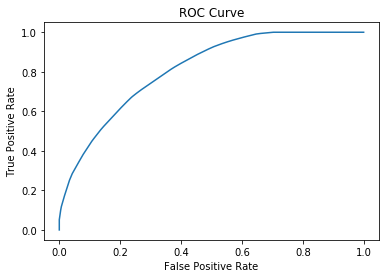

Area Under the Curve: 0.8116046831955922


In [34]:
# Let's get a summary of the data.
training_summary = lr_model.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

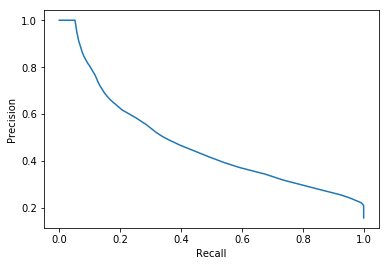

In [52]:
# Convert DataFrame to Pandas DataFrame.
pr = training_summary.pr.toPandas()

# Plot model recall and precision.
plt.plot(pr['recall'],pr['precision'])

# Define the labels and show the graph. 
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Random Forest Classifier

In [53]:
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(pipe_df)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(pipe_df)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = pipe_df.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+-------------+
|predictedLabel|label|     features|
+--------------+-----+-------------+
|           0.0|  0.0|(5,[0],[1.0])|
|           0.0|  0.0|(5,[0],[1.0])|
|           0.0|  0.0|(5,[0],[1.0])|
|           0.0|  0.0|(5,[0],[1.0])|
|           0.0|  0.0|(5,[0],[1.0])|
+--------------+-----+-------------+
only showing top 5 rows

Test Error = 0.155801
RandomForestClassificationModel (uid=rfc_6a40318e57db) with 10 trees


### GBTClassifier

In [56]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(pipe_df)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(pipe_df)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = pipe_df.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+-------------+
|prediction|indexedLabel|     features|
+----------+------------+-------------+
|       0.0|         0.0|    (5,[],[])|
|       0.0|         0.0|(5,[0],[1.0])|
|       0.0|         0.0|(5,[0],[1.0])|
|       0.0|         0.0|(5,[0],[1.0])|
|       0.0|         0.0|(5,[0],[1.0])|
+----------+------------+-------------+
only showing top 5 rows

Test Error = 0.168623
GBTClassificationModel (uid=GBTClassifier_48f89a5768b1d258dc1c) with 10 trees


### Multiple iteration

#### "Class" VS "isWide"

In [57]:
df_isWide2 = df_pre.select('Class', 'Order', 'Family', 'isWide')

In [58]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)
# First create a string indexer which converts every string into a number, such as male = 0 and female = 1.
# A number will be assigned to every category in the column.
Class_indexer = StringIndexer(inputCol='Class',outputCol='ClassIndex')

isWide_indexer = StringIndexer(inputCol='isWide',outputCol='label')

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# Multiple columns are collapsed into one. 
# This makes it easier to process when you have multiple classes.
Class_encoder = OneHotEncoder(inputCol='ClassIndex',outputCol='ClassVec')

# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['ClassVec'], outputCol="features")

In [59]:
from pyspark.ml import Pipeline
# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[Class_indexer, isWide_indexer, Class_encoder, assembler])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(df_isWide2)

# Incorporate results into a new DataFrame.
#pipe_df_Level = pipeline_model.transform(df_Level)
pipe_df = pipeline_model.transform(df_isWide2)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')

In [60]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(pipe_df)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(pipe_df)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = pipe_df.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+-------------+
|prediction|indexedLabel|     features|
+----------+------------+-------------+
|       0.0|         0.0|(5,[0],[1.0])|
|       0.0|         0.0|(5,[0],[1.0])|
|       0.0|         0.0|(5,[0],[1.0])|
|       0.0|         0.0|(5,[0],[1.0])|
|       0.0|         0.0|(5,[0],[1.0])|
+----------+------------+-------------+
only showing top 5 rows

Test Error = 0.156284
GBTClassificationModel (uid=GBTClassifier_4754b9cef4a4ca088244) with 10 trees


In [61]:
from numpy import sum

def weighted_mean(df_Level):
    vals = list(df_Level)  # save the values from the iterator
    sum_of_weights = sum(tup[1] for tup in df_Level)
    return sum(1. * tup[0] * tup[1] / sum_of_weights for tup in df_Level)

df.rdd.map(
    lambda x: (x[0], tuple(x[1:]))  # reshape to (key, val) so grouping could work
).groupByKey().mapValues(
    weighted_mean
).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 965.0 failed 1 times, most recent failure: Lost task 0.0 in stage 965.0 (TID 2536, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/rdd.py", line 1949, in <lambda>
    map_values_fn = lambda kv: (kv[0], f(kv[1]))
  File "<ipython-input-61-5cc80d667d44>", line 5, in weighted_mean
  File "/home/ubuntu/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py", line 1869, in sum
    res = _sum_(a)
TypeError: unsupported operand type(s) for +: 'int' and 'str'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1965)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/rdd.py", line 1949, in <lambda>
    map_values_fn = lambda kv: (kv[0], f(kv[1]))
  File "<ipython-input-61-5cc80d667d44>", line 5, in weighted_mean
  File "/home/ubuntu/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py", line 1869, in sum
    res = _sum_(a)
TypeError: unsupported operand type(s) for +: 'int' and 'str'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:322)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
